<a href="https://colab.research.google.com/github/sridharnandigam/GestureRecognition/blob/model_update/gesture_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun 22 13:33:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 33kB/s 


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
!tar -xvf WISDM_ar_latest.tar.gz

Downloading...
From: https://drive.google.com/uc?id=152sWECukjvLerrVG2NUO8gtMFg83RKCF
To: /content/WISDM_ar_latest.tar.gz
11.4MB [00:00, 100MB/s]
WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [3]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('gesture_data.csv', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

df['user_id'] = df.user_id.astype(int)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(df.head())
print("Shape", df.shape)

   user_id activity     timestamp    x_axis    y_axis    z_axis
0       30   waving  4.582675e+09 -0.353728  5.283476  7.901423
1       30   waving  4.588676e+09 -0.277715  5.296046  8.208766
2       30   waving  4.594678e+09 -0.277715  5.296046  8.208766
3       30   waving  4.607681e+09 -0.238512  5.258937  8.365580
4       30   waving  4.614681e+09 -0.201104  5.226916  8.395206
Shape (131205, 6)


In [12]:
new_df = df[['user_id', 'activity']]

df25 = new_df[new_df['user_id'] == 25]
df26 = new_df[new_df['user_id'] == 26]
df27 = new_df[new_df['user_id'] == 27]
df28 = new_df[new_df['user_id'] == 28]
df29 = new_df[new_df['user_id'] == 29]
df30 = new_df[new_df['user_id'] == 30]

df_list = [df25, df26, df27, df28, df29, df30]
collabels = [25, 26, 27, 28 , 29, 30]
rowlabels = ['waving', 'semicircle', 'outwardsL', 'outwardsR', 'dab', 'lineV', 'lineH', 'xmark', 'circle', 'towards', 'drinking']
data = {}
epic_df = pd.DataFrame(index = rowlabels, columns = collabels)

for d in df_list:
  print(d.activity.value_counts())

#print(new_df.apply(pd.Series.value_counts))



circle        3786
waving        2746
outwardsL     2233
outwardsR     1356
lineH         1282
xmark         1249
semicircle     705
Name: activity, dtype: int64
waving        3935
towards       2935
semicircle    1996
outwardsR     1966
xmark         1935
lineH         1923
outwardsL     1857
drinking      1763
dab           1749
circle        1514
lineV         1493
Name: activity, dtype: int64
lineV         3066
towards       2897
lineH         2070
xmark         1950
dab           1741
outwardsL     1705
circle        1479
drinking      1265
outwardsR     1109
semicircle     932
waving         548
Name: activity, dtype: int64
waving        2316
lineV         2253
circle        2005
xmark         1900
drinking      1855
lineH         1796
outwardsR     1771
towards       1768
dab           1608
semicircle    1566
outwardsL     1543
Name: activity, dtype: int64
semicircle    3801
waving        2496
lineV         2327
xmark         2268
lineH         2121
outwardsL     2030
outwardsR 

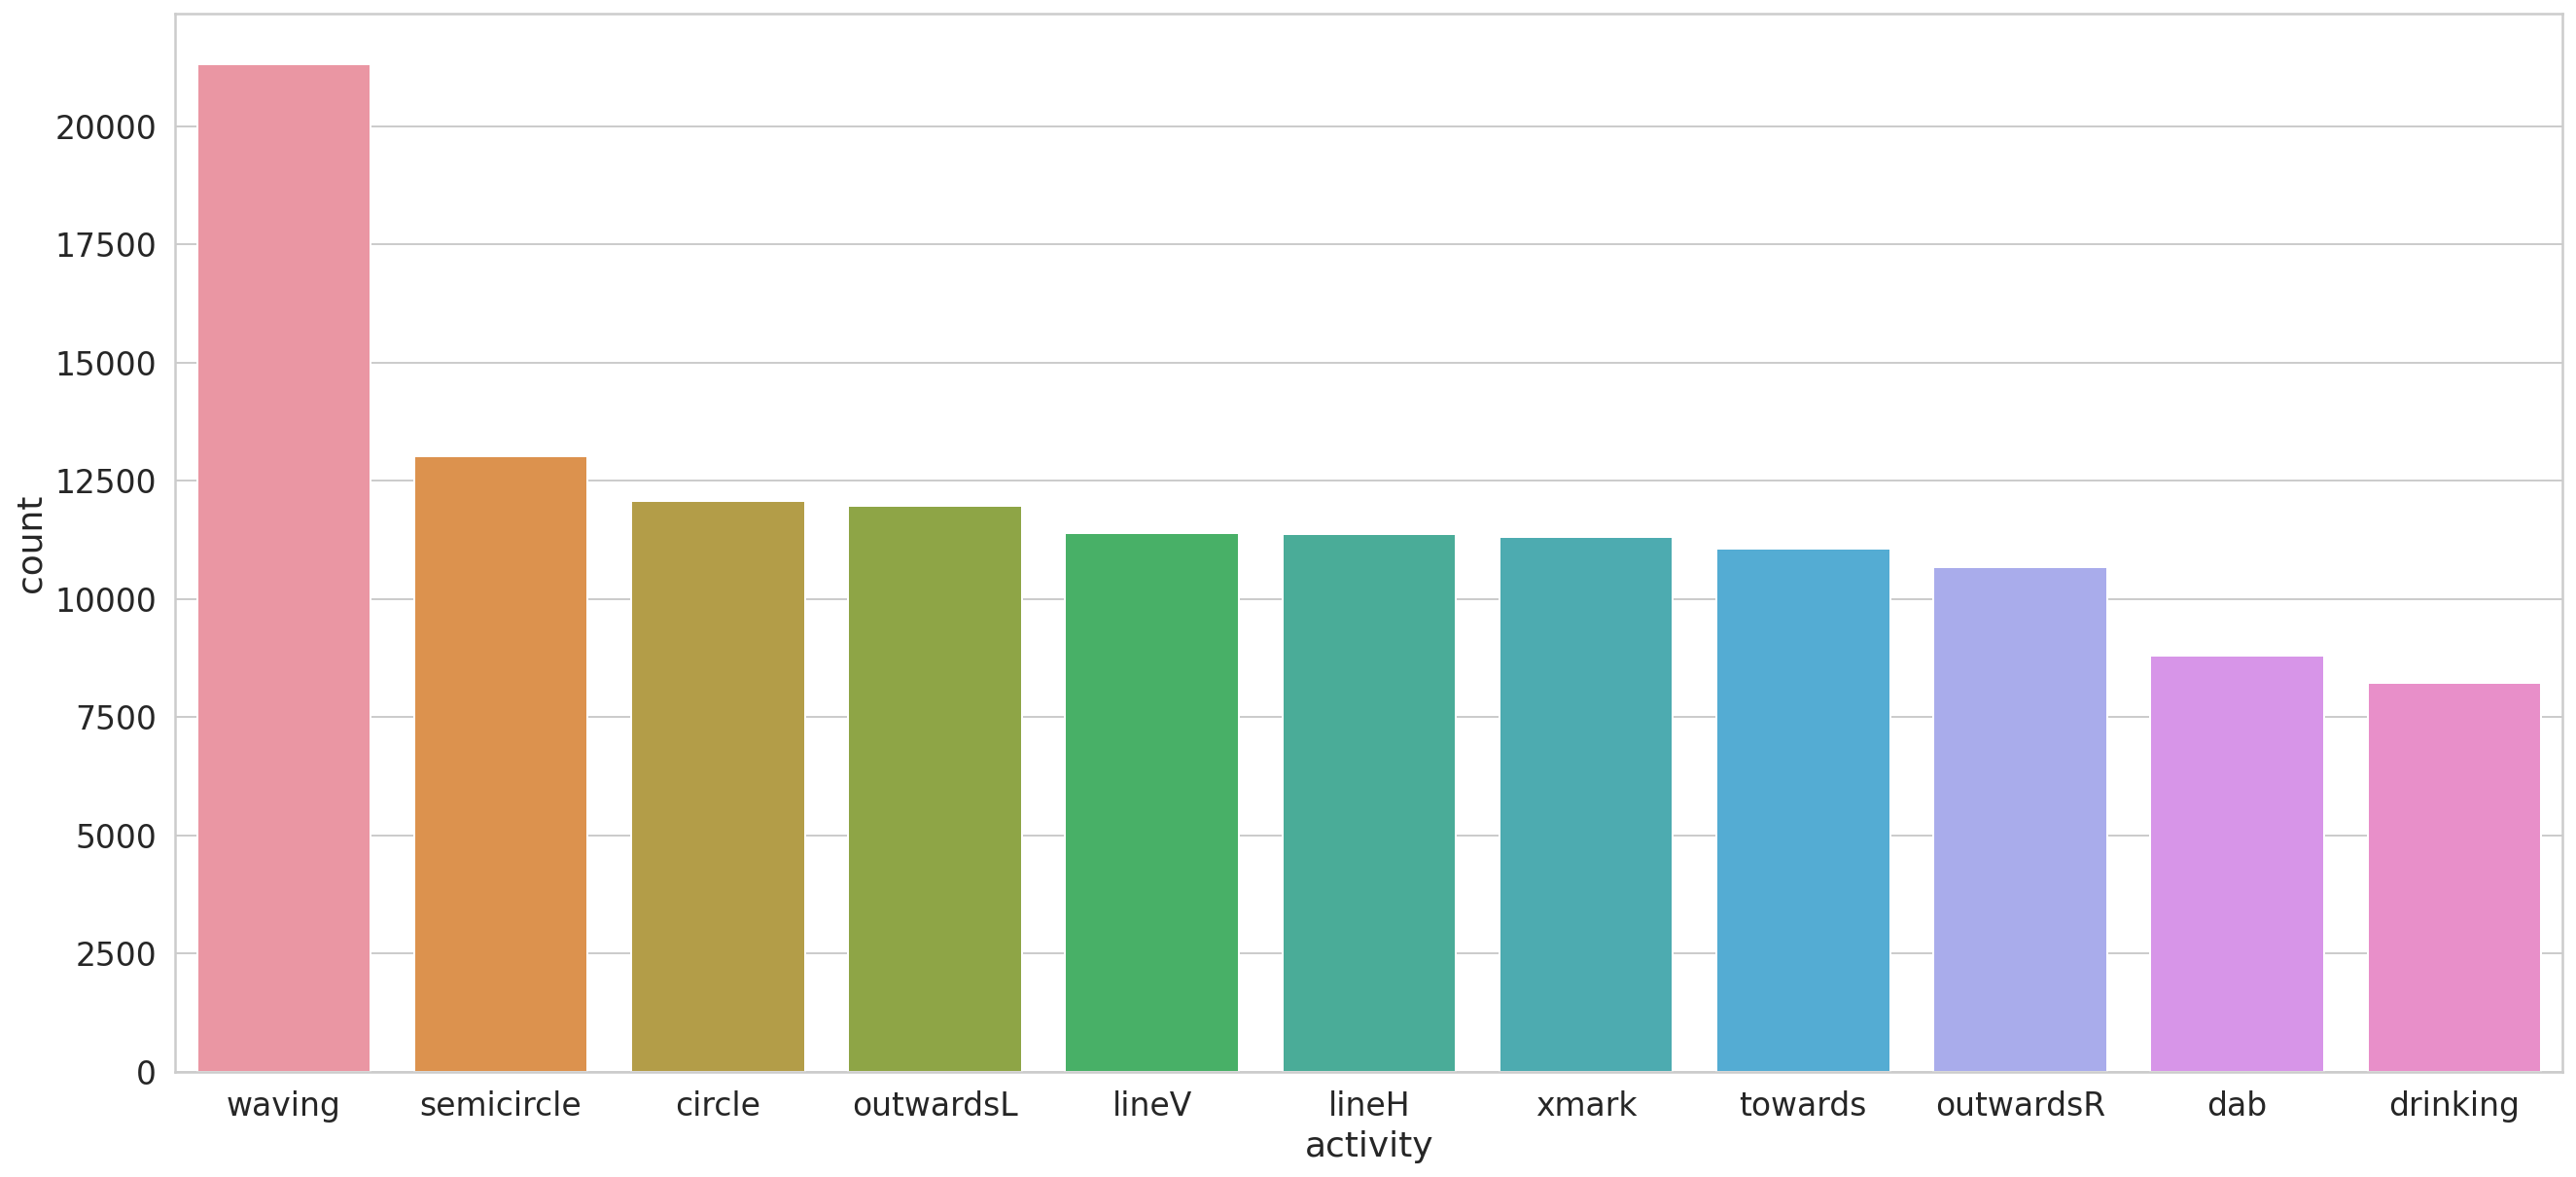

In [5]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

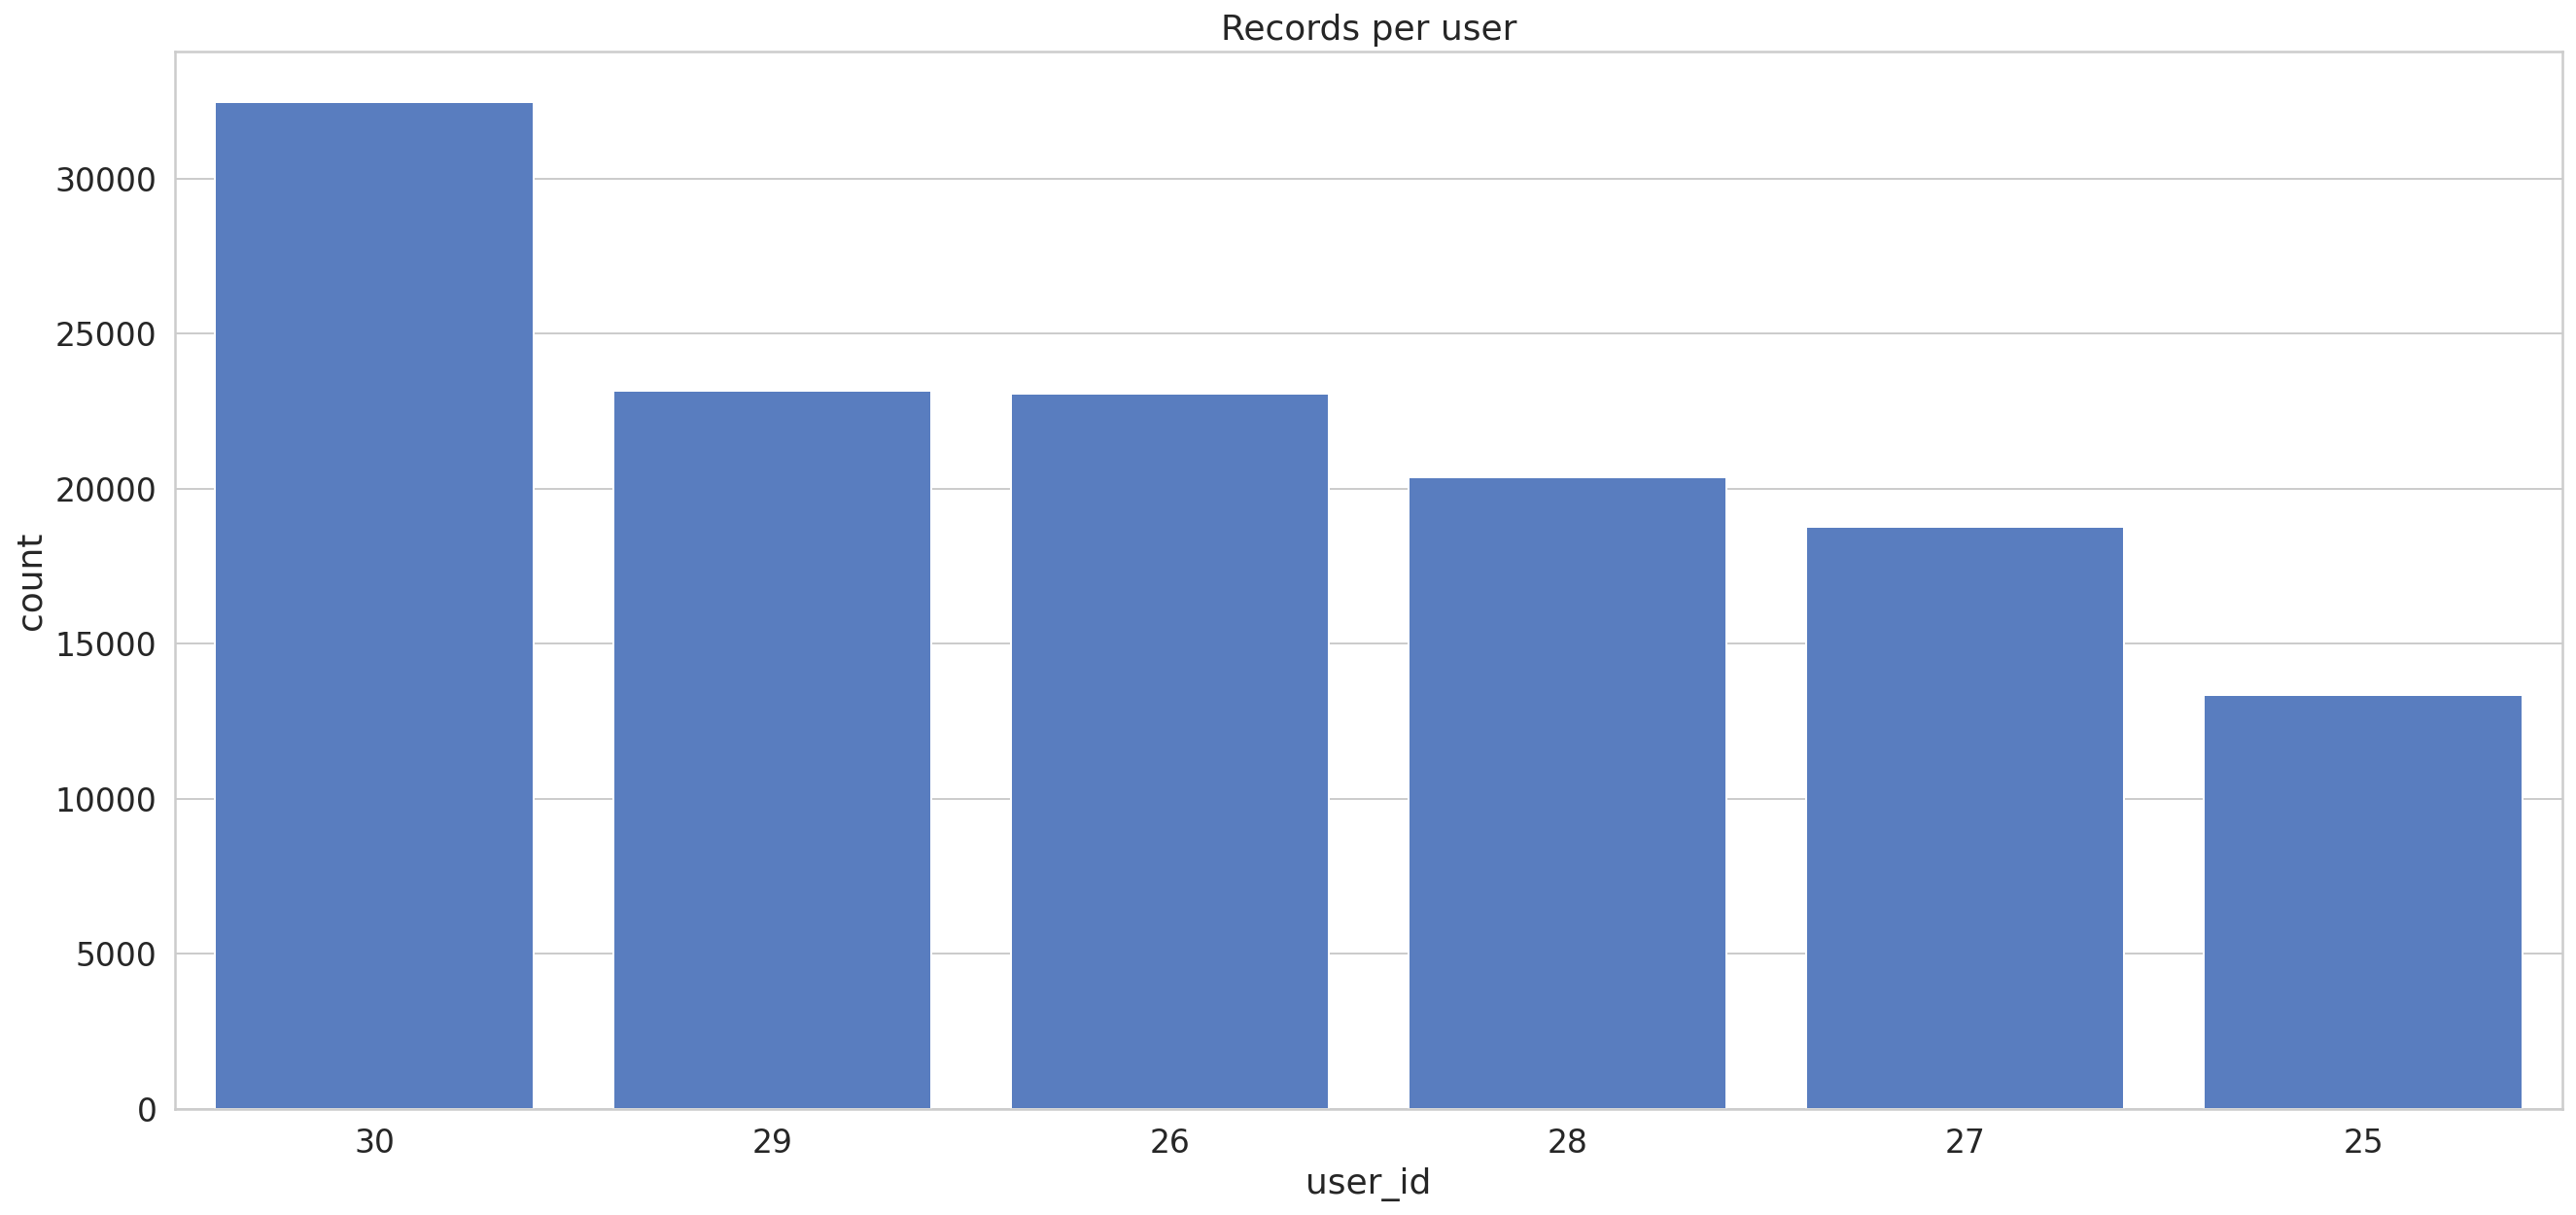

In [6]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [7]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

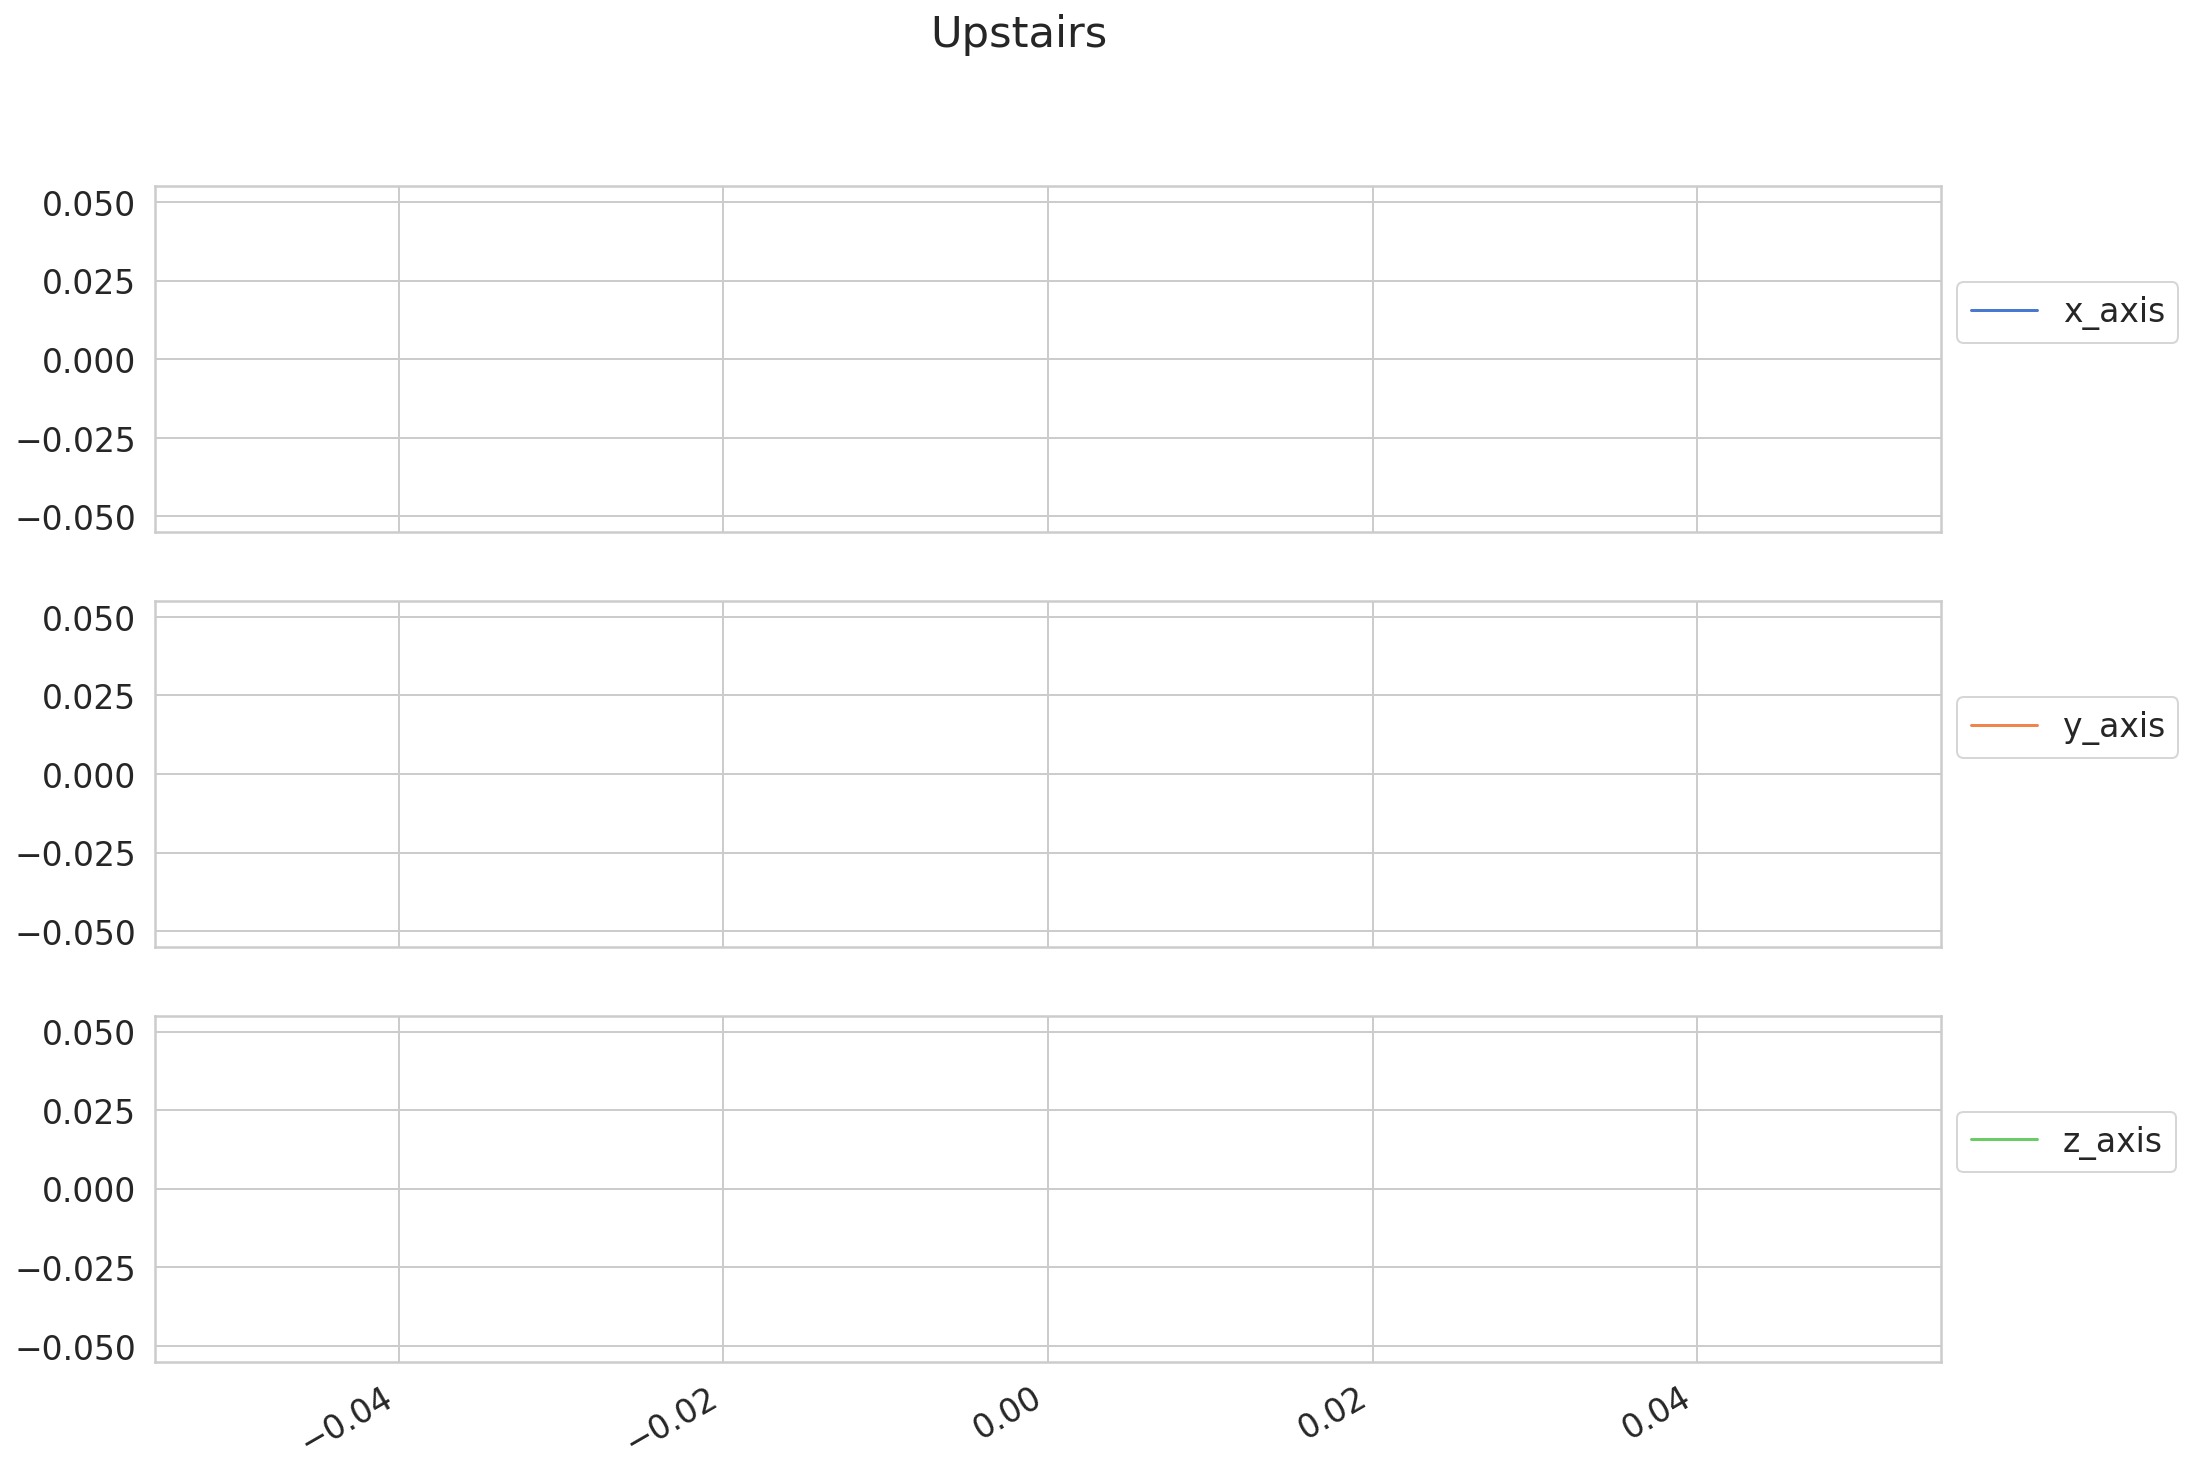

In [ ]:
plot_activity("Upstairs", df);

In [8]:
df['user_id'] = df['user_id'].astype(int)
df_train = df[df['user_id'] > 26]
df_test = df[df['user_id'] <= 26]

In [9]:
df_test.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
14780,26,waving,2.625991e+09,0.391435,4.025677,8.900661
14781,26,waving,2.668957e+09,0.390837,3.978394,8.961112
14782,26,waving,2.717996e+09,0.427945,3.885323,8.975475
14783,26,waving,2.768635e+09,0.330583,3.975102,8.941061
14784,26,waving,2.835383e+09,0.287890,3.983780,8.927295


In [10]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [12]:
print(X_train.shape, y_train.shape)

#Added code to save raw array before one hot encoding

raw_ytrain = y_train
raw_ytest = y_test

(2365, 200, 3) (2365, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [14]:
print(X_train.shape, y_train.shape)

(2365, 200, 3) (2365, 11)


In [15]:
#testing recall and precision, ignore for now
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_test, y_pred)
    recall = recall_m(y_test, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [16]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='tanh'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True
)
#validation_split=0.1

Epoch 1/30
37/37 [==============================] - 2s 44ms/step - loss: 1.6322 - acc: 0.4063 - val_loss: 1.6023 - val_acc: 0.4625
Epoch 2/30
37/37 [==============================] - 1s 24ms/step - loss: 1.1271 - acc: 0.5539 - val_loss: 1.2602 - val_acc: 0.5143
Epoch 3/30
37/37 [==============================] - 1s 24ms/step - loss: 0.9242 - acc: 0.6330 - val_loss: 1.2451 - val_acc: 0.5684
Epoch 4/30
37/37 [==============================] - 1s 25ms/step - loss: 0.7910 - acc: 0.6960 - val_loss: 1.0030 - val_acc: 0.6501
Epoch 5/30
37/37 [==============================] - 1s 24ms/step - loss: 0.6684 - acc: 0.7476 - val_loss: 0.9625 - val_acc: 0.6369
Epoch 6/30
37/37 [==============================] - 1s 24ms/step - loss: 0.5428 - acc: 0.7789 - val_loss: 0.8767 - val_acc: 0.7119
Epoch 7/30
37/37 [==============================] - 1s 25ms/step - loss: 0.7396 - acc: 0.7277 - val_loss: 0.7429 - val_acc: 0.7528
Epoch 8/30
37/37 [==============================] - 1s 24ms/step - loss: 0.6356 - a

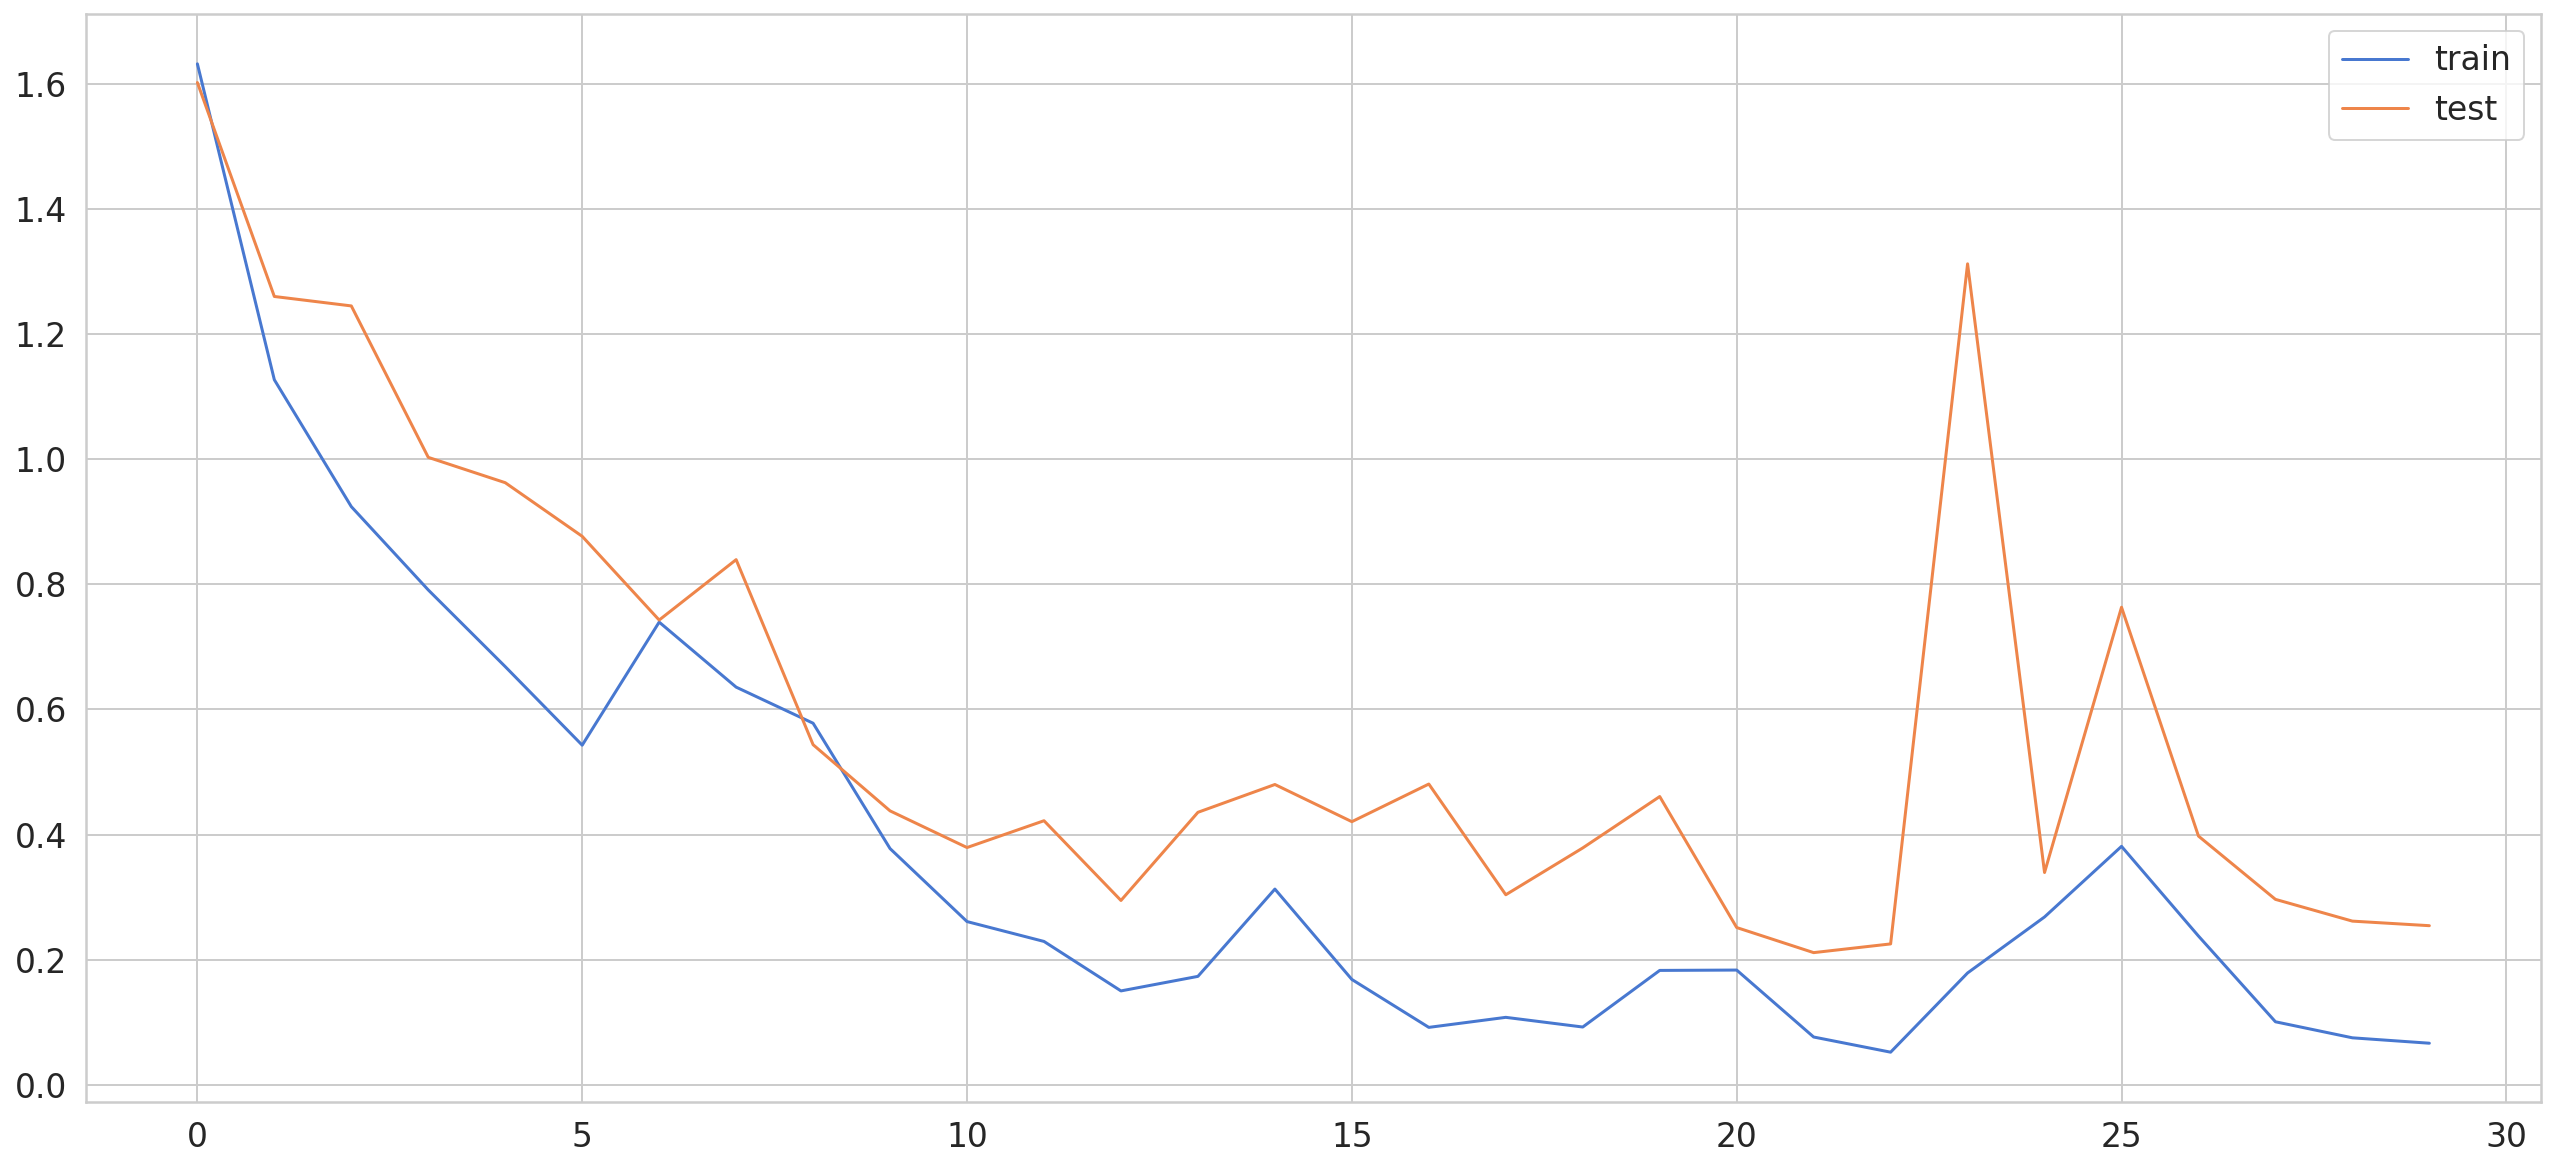

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [19]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 0s 13ms/step - loss: 0.2542 - acc: 0.9448


[0.25419774651527405, 0.9448123574256897]

In [20]:
y_pred = model.predict(X_test)

In [43]:
'''
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred_dim = y_pred[:, 0]
#y_classes_dim = y_classes[:, 0]
y_true_dim = y_test[:, 0]

#accuracy = accuracy_score(raw_ytest, y_classes)

#classification_report(y_true_dim, y_pred_dim)
precision_score(y_test, y_pred, average="weighted")
'''

'\nfrom sklearn.metrics import precision_score\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.metrics import recall_score\nfrom sklearn.metrics import f1_score\nfrom sklearn.metrics import classification_report\n\ny_pred_dim = y_pred[:, 0]\n#y_classes_dim = y_classes[:, 0]\ny_true_dim = y_test[:, 0]\n\n#accuracy = accuracy_score(raw_ytest, y_classes)\n\n#classification_report(y_true_dim, y_pred_dim)\nprecision_score(y_test, y_pred, average="weighted")\n'

In [21]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(21, 19)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(230, 30, n=9),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_title('Confusion Matrix')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names, rotation=0)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

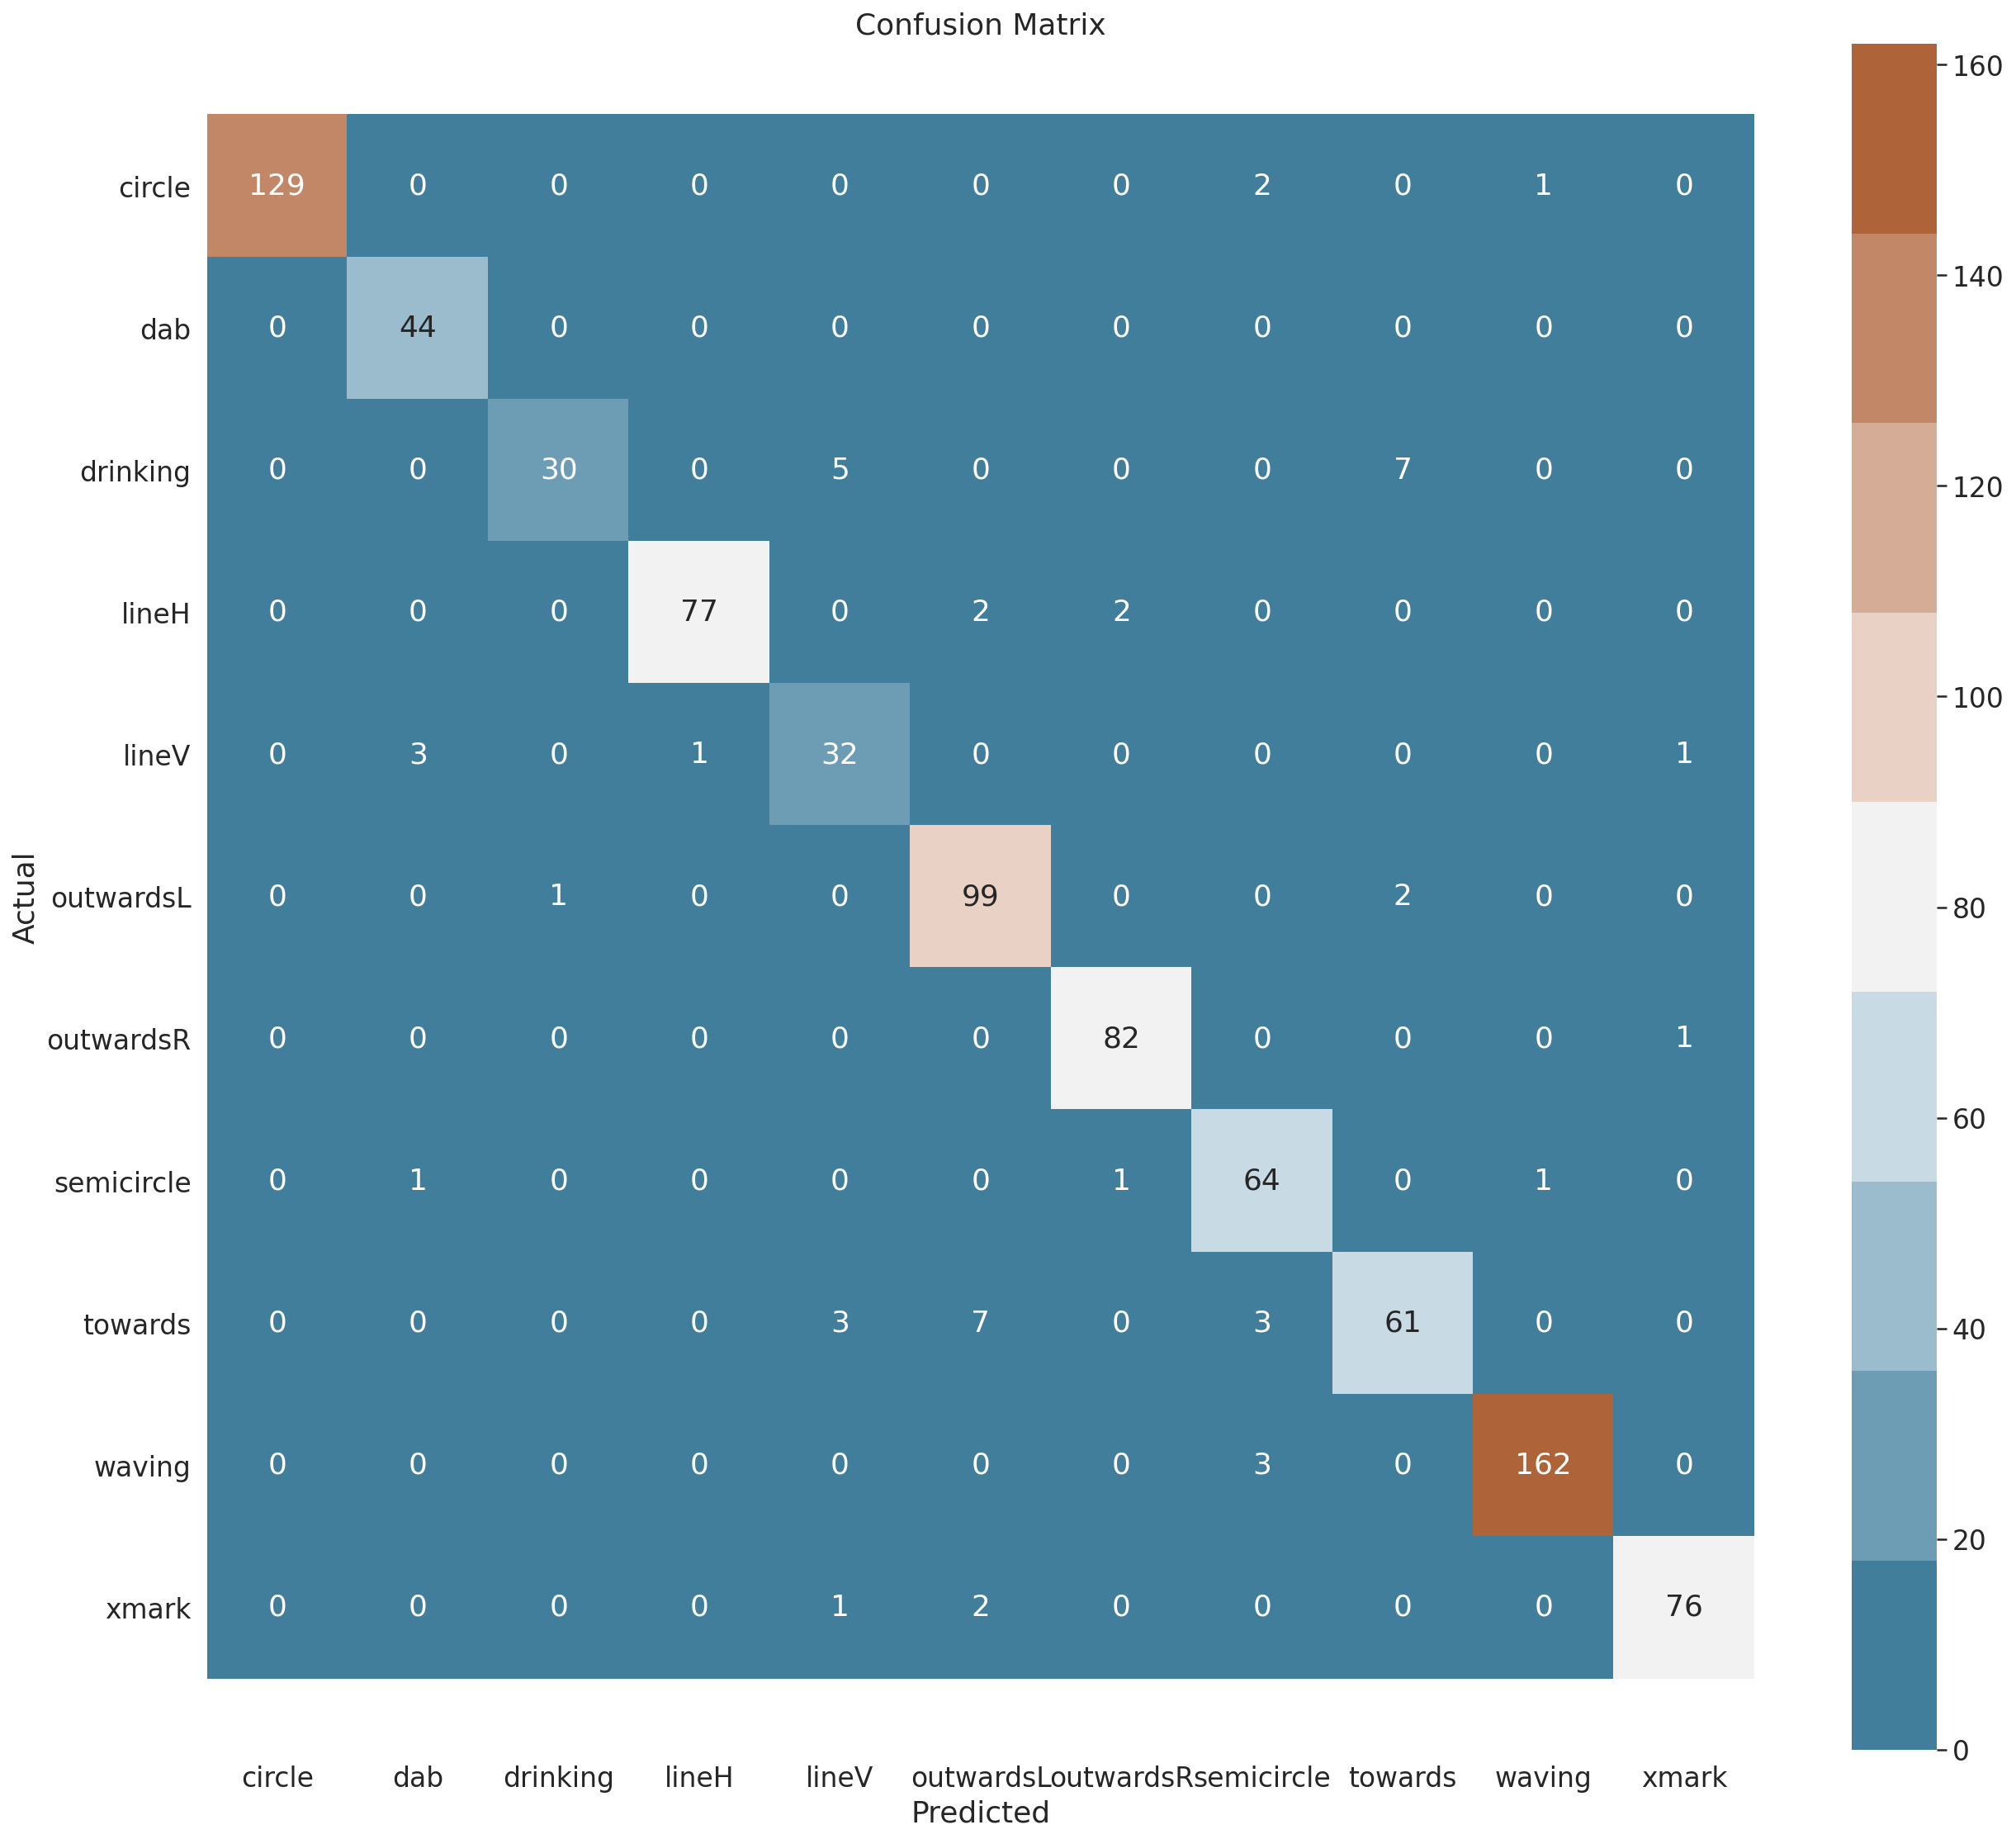

In [22]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)